In [135]:
!pip install "basemap == 1.3.0b1" "basemap-data == 1.3.0b1"

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [136]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
from mpl_toolkits.basemap import Basemap

In [137]:
#create nodes
G = nx.DiGraph()
nodes = open("Nodes.txt", 'r').read().split('\n')
lat = open("Latitude.txt", 'r').read().split('\n')
lon = open("Longitude.txt", 'r').read().split('\n')
airports = np.column_stack((nodes, lat, lon))

airports = airports[0:len(airports)-1,:]
clean_airports = []

for i in airports:
  if float(i[2]) <= 180 and float(i[2]) >= -180 and float(i[1]) <= 90 and float(i[1]) >= -90:
    clean_airports.append(i)
    G.add_node(i[0], pos = (i[1], i[2]))
clean_airports = np.asarray(clean_airports)

In [138]:
len(list(G.nodes))

5998

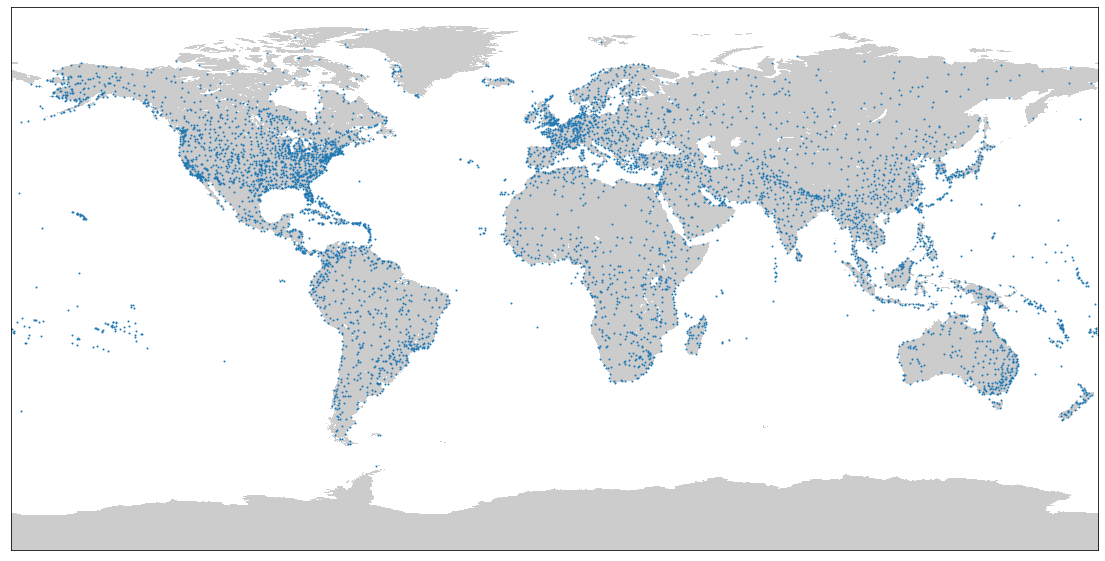

In [139]:
fig = plt.figure()
fig.set_size_inches(20, 10)
pos=nx.get_node_attributes(G,'pos')
for k, v in pos.items():
  pos[k] = (float(v[1]), float(v[0]))
nx.draw_networkx_nodes(G, pos, node_size = 1, label = False)
plt.xlim([-180, 180])
plt.ylim([-90, 90])
plt.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
plt.xticks(range(-180,181, 30))
plt.yticks(range(-90,91, 15))

m = Basemap(projection='cyl', resolution=None,
            llcrnrlat=-90, urcrnrlat=90,
            llcrnrlon=-180, urcrnrlon=180, )
m.drawlsmask()

In [140]:
sou = open("Source.txt", 'r').read().split('\n')
des = open("Destination.txt", 'r').read().split('\n')
routes = np.column_stack((sou, des))
print(len(routes))

67663


In [141]:
delete_list_sou = list(set(routes[:,0]) - set(clean_airports[:,0]))

In [142]:
delete_list_des = list(set(routes[:,1]) - set(clean_airports[:,0]))

In [143]:
print(delete_list_sou)

['BLD', 'DIW', 'KTB', 'HKB', 'BAQ', 'KKB', 'SSB', 'KKI', 'KTW', 'AOS', 'CZH', 'DIJ', 'DGA', 'GOA', 'CBS', 'QOQ', 'FBS', 'KUS', 'TSF', 'MPP', 'RMI', 'KOZ', 'NSQ', 'AUA', 'KPB', 'KAE', 'WBB', 'IUI', 'TCR', 'SRV', 'THD', 'FVM', 'TAL', 'MRA', 'PLJ', 'TQI', 'KCG', 'EBJ', 'FSZ', 'UGB', 'SAX', 'LNV', 'TKE', 'KHQ', 'GSM', 'WTL', 'GRV', 'KCC', 'OUA', 'IOT', 'ELL', 'HYL', 'LMC', 'CDG', 'CXF', 'BVV', 'TTQ', 'KCL', 'RCE', 'PYC', 'IAO', 'BCD', 'INB', 'MYQ', 'TGC', 'KXU', 'WSX', 'PVE', 'LCR', 'WWP', 'SZI', 'TNK', 'OHH', 'SQS', 'PUM', 'RIG', 'TZA', 'YKT', 'PEG', 'SRK', 'JIJ', 'RDV', 'GHE', 'VRN', 'GCW', 'MJU', 'CKX', 'JUU', 'SVS', 'TVS', 'QUV', 'SGG', 'SVK', 'PPN', 'ORI', 'PPV', 'CGA', 'ATT', 'NIQ', 'TLT', 'SXP', 'PND', 'QUO', 'ZIG', 'CIA', 'NQU', 'QJH', 'KBC', 'ADZ', 'TQA', 'SIC', 'XEQ', 'NUP', 'IKE', 'BCV', 'MLH', 'SHC', 'TCD', 'IGM', 'KGX', 'UPK', 'EDA', 'PEC', 'INC', 'DLI', 'KCQ', 'BZO', 'OLH', 'PNL', 'KWF', 'ACU', 'SLI', 'MNT', 'OTD', 'ORZ', 'SAE', 'ZBL', 'PSA', 'PHO', 'ZDY', 'QUB', 'LBP', 'LGQ'

In [144]:
print(delete_list_des)

['BLD', 'DIW', 'KTB', 'HKB', 'BSS', 'BAQ', 'KKB', 'SSB', 'KKI', 'KTW', 'AOS', 'CZH', 'DIJ', 'DGA', 'GOA', 'CBS', 'QFX', 'QOQ', 'FBS', 'KUS', 'TSF', 'MPP', 'RMI', 'KOZ', 'NSQ', 'AUA', 'KPB', 'KAE', 'WBB', 'IUI', 'TCR', 'SRV', 'THD', 'FVM', 'TAL', 'MRA', 'PLJ', 'TQI', 'KCG', 'EBJ', 'FSZ', 'UGB', 'SAX', 'LNV', 'TKE', 'KHQ', 'GSM', 'WTL', 'GRV', 'KCC', 'OUA', 'IOT', 'ELL', 'CZJ', 'HYL', 'MTE', 'LMC', 'CDG', 'CXF', 'BVV', 'TTQ', 'KCL', 'RCE', 'PYC', 'IAO', 'BCD', 'INB', 'MYQ', 'TGC', 'KXU', 'WSX', 'PVE', 'LCR', 'WWP', 'SZI', 'TNK', 'OHH', 'SQS', 'PUM', 'RIG', 'TZA', 'YKT', 'PEG', 'SRK', 'JIJ', 'RDV', 'GHE', 'VRN', 'GCW', 'MJU', 'CKX', 'JUU', 'SVS', 'TVS', 'QUV', 'SGG', 'SVK', 'PPN', 'ORI', 'PPV', 'CGA', 'ATT', 'KPR', 'NIQ', 'TLT', 'SXP', 'PND', 'QUO', 'ZIG', 'CIA', 'NQU', 'QJH', 'KBC', 'ADZ', 'TQA', 'SIC', 'XEQ', 'NUP', 'IKE', 'MLH', 'BCV', 'SHC', 'TCD', 'IGM', 'KGX', 'UPK', 'EDA', 'PEC', 'INC', 'DLI', 'KCQ', 'BZO', 'OLH', 'PNL', 'KWF', 'ACU', 'SLI', 'MNT', 'OTD', 'ORZ', 'SAE', 'ZBL', 'PSA'

In [145]:
delete_list = []
for i in range(len(routes)):
  if routes[i][0] in delete_list_sou or routes[i][1] in delete_list_des:
    delete_list.append(i)
print(len(delete_list))

3933


In [146]:
routes = np.delete(routes, delete_list, 0)
print(len(routes))

63730


In [147]:
for i in routes:
  G.add_edge(i[0], i[1])

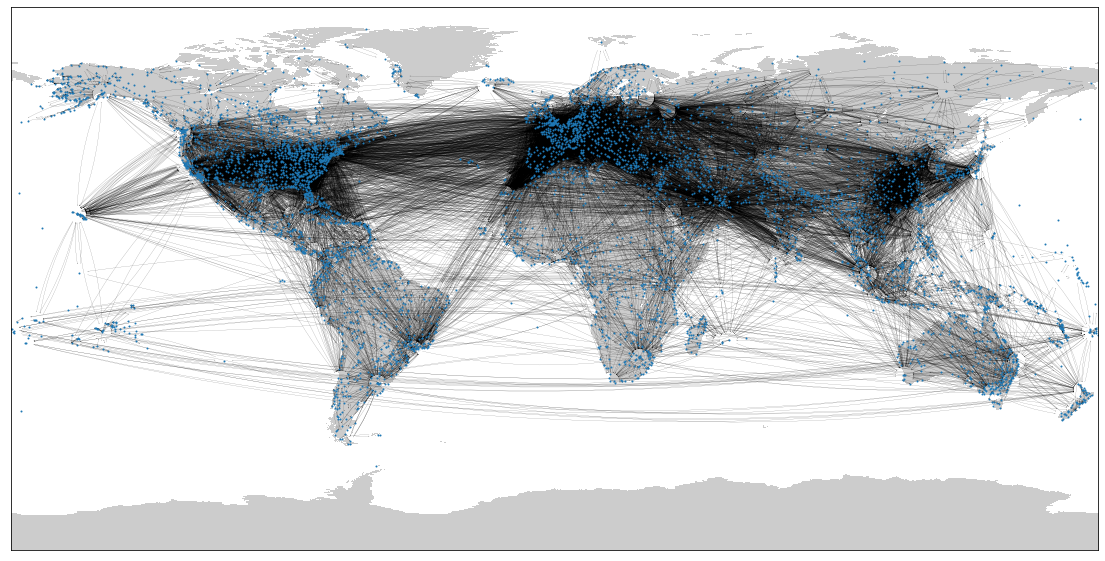

In [148]:
fig = plt.figure()
fig.set_size_inches(20, 10)
pos=nx.get_node_attributes(G,'pos')

for k, v in pos.items():
    pos[k] = (float(v[1]), float(v[0]))
    
nx.draw_networkx_nodes(G, pos, node_size = 1, label = False)
nx.draw_networkx_edges(G, pos,width = 0.1, arrowsize = 1 ,connectionstyle="arc3,rad=0.1")
plt.xlim([-180, 180])
plt.ylim([-90, 90])
plt.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
plt.xticks(range(-180,181, 30))
plt.yticks(range(-90,91, 15))

m = Basemap(projection='cyl', resolution=None,
            llcrnrlat=-90, urcrnrlat=90,
            llcrnrlon=-180, urcrnrlon=180, )
m.drawlsmask()


In [149]:
# create edge attribute weight with default None 
nx.set_edge_attributes(G, values=None, name = 'weight')

#count the occurance of the airport in the routes database
sources, sources_counts=np.unique(routes[:,0], return_counts=True)
des, des_counts=np.unique(routes[:,1], return_counts=True)

# create edge attribute source_occurrence with default None
nx.set_node_attributes(G, values=0, name = 'so')
for node in list(sources):
    G.nodes[node]['so'] = list(sources_counts)[list(sources).index(node)]

# create edge attribute destination_occurrence with default None
nx.set_node_attributes(G, values=0, name = 'do')
for node in list(des):
    G.nodes[node]['do'] = list(des_counts)[list(des).index(node)]
  
def add_weight_to_edges(graph):
    for node in graph.nodes:
        neighbors = [n for n in G.neighbors(node)]
        for nb in neighbors:
            graph[node][nb]['weight'] = np.mean([graph.nodes[node]['so'],G.nodes[node]['do'],graph.nodes[nb]['so'],graph.nodes[nb]['do']])

add_weight_to_edges(G)

In [150]:
# create node attribute degree
nx.set_node_attributes(G, values = 0, name = 'degree')
for i in G.nodes():
  G.nodes[i]['degree'] = G.degree[i]

In [158]:
# SIR model

import math
import random

# Set edge attribute weight fraction (weight of an edge/average number of degrees in the neighborhood of the source node)
nx.set_edge_attributes(G, values=None, name = 'weight fraction')

avg_neighbor_deg = nx.average_neighbor_degree(G,source = 'out', target = 'in', weight = 'weight')

for i in G.edges():
  G.edges[i]['weight fraction'] = G.edges[i]['weight']/avg_neighbor_deg[i[0]]

# Infection and Recovery and time coefficients
beta = 1
gamma = 0.02
time = 1
ni = (1-gamma/beta)*(math.exp(beta - gamma)**time/(1+math.exp(beta - gamma)**time)) # infected portion

# Infect the random airport

nx.set_node_attributes(G, values = 0, name = 'infected population')
rnd  = random.choice(list(G.nodes()))
G.nodes[rnd]['infected population'] = ni*G.nodes[rnd]['degree']
print(G.nodes[rnd]['infected population'])
# Infected 'population' at each neigbouring airport


4.275396312085841


In [160]:
def infect(G, cycles):
  for i in range(cycles):
    for node in G.nodes():
      neighbors = [n for n in G.neighbors(node)]
      for nb in neighbors:
        if G.nodes[node]['infected population'] != 0:
          G.nodes[nb]['infected population'] = ni*G.nodes[node]['degree']*G.edges[node,nb]['weight fraction']

In [161]:
infect(G, 10)

In [162]:
for i in G.nodes():
  if G.nodes[i]['infected population'] != 0:
    print(i)

GKA
MAG
HGU
LAE
POM
WWK
UAK
GOH
SFJ
THU
AEY
EGS
IFJ
KEF
RKV
YAM
YAY
YBC
YBG
YBK
YBL
YBR
YCB
YCD
YCG
YCL
YCO
YCY
YZS
YDF
YDQ
YEG
YEK
YEV
YFB
YFC
YFO
YFS
YGK
YGL
YGP
YGR
YHD
YHI
YHK
YHM
YHU
YHY
YHZ
YIO
YJT
YKA
YKF
YKL
YLL
YLW
YMM
YMO
YNA
YOJ
YOW
YPL
YPN
YPR
YPY
YQB
YQF
YQG
YQK
YQL
YQM
YQQ
YQR
YQT
YQU
YQX
YQY
YQZ
YRB
YRT
YSB
YSJ
YSM
YSY
YTE
YTH
YTS
YTZ
YUB
YUL
YUT
YUX
YUY
YVM
YVO
YVP
YVQ
YVR
YWG
YWK
YWL
YXC
YXE
YXH
YXJ
YXL
YXP
YXS
YXT
YXU
YXX
YXY
YYB
YYC
YYD
YYE
YYF
YYG
YYH
YYJ
YYQ
YYR
YYT
YYU
YYY
YYZ
YZF
YZP
YZR
YZT
YZV
ZFM
BJA
ALG
DJG
TMR
MZW
AAE
CZL
TEE
HRM
TID
CFK
TLM
ORN
MUW
AZR
BSK
ELG
GHA
HME
INZ
TGR
OGX
IAM
COO
BOY
ACC
TML
NYI
TKD
ABJ
ABV
BNI
CBQ
ENU
IBA
ILR
JOS
KAD
KAN
LOS
PHC
SKO
YOL
NIM
MIR
TUN
GAF
GAE
DJE
SFA
TOE
LFW
ANR
BRU
CRL
LGG
OST
SXF
DRS
ERF
FRA
FMO
HAM
CGN
DUS
NUE
LEJ
SCN
STR
TXL
HAJ
BRE
HHN
MHG
XFW
LBC
PAD
DTM
AGB
FDH
ZQW
KSF
GWT
URE
TLL
TAY
HEL
IVL
JOE
JYV
KEM
KAJ
KOK
KAO
KTT
KUO
LPP
MHQ
OUL
POR
RVN
SVL
TMP
TKU
VAA
BFS
BHD
LDY
BHX
GLO
MAN
NQY
CWL
BRS
LPL
LTN
BOH
SOU


In [163]:
nx.set_node_attributes(G, values = 'b', name = 'color')
for i in G.nodes():
  if G.nodes[i]['infected population'] != 0:
    G.nodes[i]['color'] = 'r'

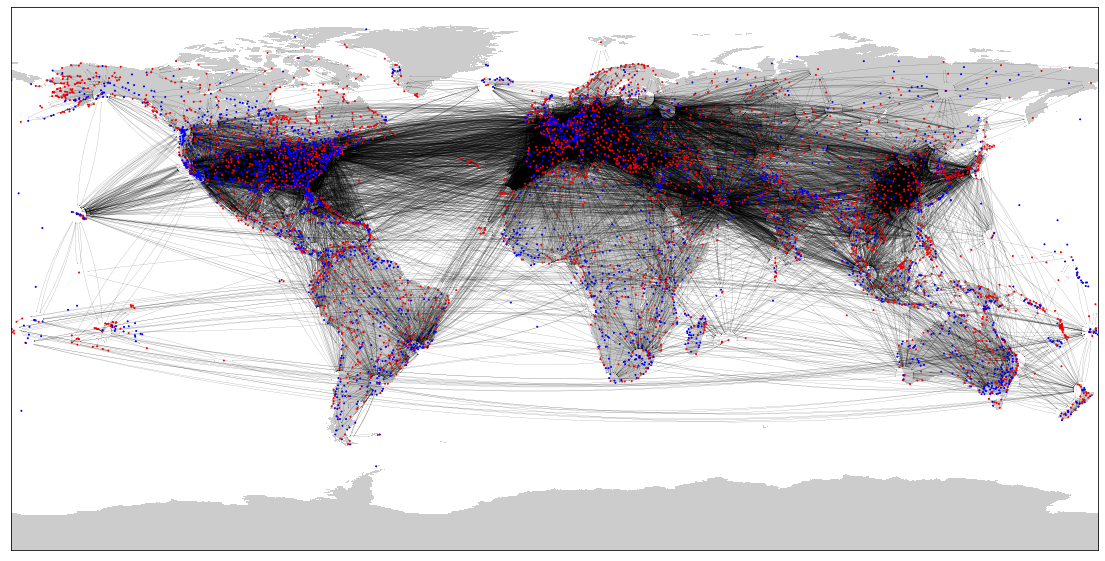

In [164]:
fig = plt.figure()
fig.set_size_inches(20, 10)
pos=nx.get_node_attributes(G,'pos')
color=nx.get_node_attributes(G,'color')

for k, v in pos.items():
    pos[k] = (float(v[1]), float(v[0]))
    
nx.draw_networkx_nodes(G, pos, node_color = color.values(), node_size = 1, label = False)
nx.draw_networkx_edges(G, pos,width = 0.1, arrowsize = 1 ,connectionstyle="arc3,rad=0.1")
plt.xlim([-180, 180])
plt.ylim([-90, 90])
plt.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
plt.xticks(range(-180,181, 30))
plt.yticks(range(-90,91, 15))

m = Basemap(projection='cyl', resolution=None,
            llcrnrlat=-90, urcrnrlat=90,
            llcrnrlon=-180, urcrnrlon=180, )
m.drawlsmask()
